In [1]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import glob
from keras.preprocessing.image import load_img
import os
from keras.preprocessing.image import img_to_array
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from torchsummary import summary

2022-05-10 11:42:35.312231: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-10 11:42:35.312253: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [42]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [17]:
dataset_paths = glob.glob("dataset_characters/**/*.jpg")

X = []
labels = []

for image_path in dataset_paths:
  label = image_path.split(os.path.sep)[-2]
  image = load_img(image_path,target_size=(80,80))
  image = img_to_array(image)

  X.append(image)
  labels.append(label)

X = np.array(X,dtype="float16")
labels = np.array(labels)

print("[INFO] Find {:d} images with {:d} classes".format(len(X),len(set(labels))))

X = X[:,:,:,0]/255
X = np.expand_dims(X, axis=1)
print(X.shape)

lb = LabelEncoder()
lb.fit(labels)
labels = lb.transform(labels)
auxLabels = np.copy(labels)
labels = to_categorical(labels)

import pickle 

with open('./labelEncoder.obj', 'wb') as file_lb:
    pickle.dump(lb, file_lb)

In [8]:
tensor_x = torch.Tensor(X) 
tensor_y = torch.Tensor(labels)

trainDataSet = torch.utils.data.TensorDataset(tensor_x, tensor_y)
train_loader = torch.utils.data.DataLoader(trainDataSet, batch_size=64, shuffle=True)

In [48]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        ### Convolutional section
        self.le_cnn = nn.Sequential(
            nn.Conv2d(1, 16, 5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), 

            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),

            nn.Flatten(),

            nn.Linear(12800, 36),

            nn.Softmax(0)
        )

    def forward(self, x):
        output = self.le_cnn(x)
             
        return output

cnn = CNN()
cnn.to(device)
loss_func = nn.MSELoss() 
optimizer = optim.Adam(cnn.parameters(), lr = 0.01) 

summary(cnn,(1, 80, 80))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 80, 80]             416
              ReLU-2           [-1, 16, 80, 80]               0
         MaxPool2d-3           [-1, 16, 40, 40]               0
            Conv2d-4           [-1, 32, 40, 40]          12,832
              ReLU-5           [-1, 32, 40, 40]               0
         MaxPool2d-6           [-1, 32, 20, 20]               0
           Flatten-7                [-1, 12800]               0
            Linear-8                   [-1, 36]         460,836
           Softmax-9                   [-1, 36]               0
Total params: 474,084
Trainable params: 474,084
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 2.73
Params size (MB): 1.81
Estimated Total Size (MB): 4.57
-------------------------------------------

In [47]:
num_epochs = 100
def train(num_epochs, cnn):
    cnn.train()
        
    # Train the model        
    for epoch in range(num_epochs):
        for image_batch, label in train_loader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
            # Move tensor to the proper device
            image_batch = image_batch.to(device, dtype=torch.float)
            label = label.to(device, dtype=torch.float)

            batchPreds = cnn(image_batch)

            # Evaluate loss
            loss = loss_func(batchPreds, label)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.data))        
    
        torch.save(cnn.state_dict(), './DigitClassifier{0}'.format(loss.data))

train(num_epochs, cnn)

	 partial train loss (single batch): 0.006061
	 partial train loss (single batch): 0.002020


KeyboardInterrupt: 

In [37]:
def test():
    # Test the model
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for image_batch, label in train_loader: 
            image_batch = image_batch.to(device, dtype=torch.float)
            label = label.to(device, dtype=torch.float)
            
            encoded_data = cnn(image_batch)

            for indx in range(len(encoded_data)):
                predicted = np.argmax(encoded_data[indx].cpu().squeeze().numpy())
                orig = np.argmax(label[indx].cpu().squeeze().numpy())
                if predicted == orig:
                    correct += 1
                total += 1
    accuracy = correct/total

    print('Test Accuracy of the model on the {1} test images: {0}'.format(accuracy, total))
    
test()

Test Accuracy of the model on the 37623 test images: 0.9125269117295272


In [13]:
def classifyDigit(observation):
    obs = torch.from_numpy(observation)
    obs = obs.to(device, dtype=torch.float)

    cnn.eval()
    with torch.no_grad():
        predLabel  = cnn(obs)
    predLabel = np.argmax(predLabel.cpu().numpy(),axis=1)

    return lb.inverse_transform(predLabel)

(1, 80, 80)


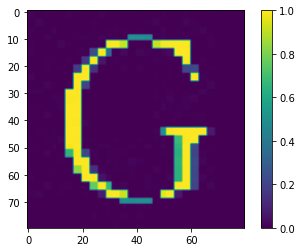

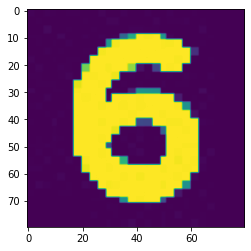

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


array(['G', '6'], dtype='<U1')

In [26]:
numpyImg = [
    trainDataSet[3540][0].unsqueeze(0).to(device, dtype=torch.float).cpu().squeeze().numpy(),
    trainDataSet[33948][0].unsqueeze(0).to(device, dtype=torch.float).cpu().squeeze().numpy()
]
numpyImg = np.expand_dims(np.array(numpyImg),1)

print(numpyImg[1].shape)
plt.imshow(numpyImg[0,0,...])
plt.colorbar()
plt.show()
plt.imshow(numpyImg[1,0,...])
plt.show()

classifyDigit(numpyImg)